# Huggingface Sagemaker-sdk - Getting Started Demo
### Binary Classification with `Trainer` and `imdb` dataset

1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    2. [Development environment](#Development-environment)  
    3. [Permissions](#Permissions)
3. [Processing](#Preprocessing)   
    1. [Tokenization](#Tokenization)  
    2. [Uploading data to sagemaker_session_bucket](#Uploading-data-to-sagemaker_session_bucket)  
4. [Fine-tuning & starting Sagemaker Training Job](#Fine-tuning-\&-starting-Sagemaker-Training-Job)  
    1. [Creating an Estimator and start a training job](#Creating-an-Estimator-and-start-a-training-job)  
    2. [Estimator Parameters](#Estimator-Parameters)   
    3. [Download fine-tuned model from s3](#Download-fine-tuned-model-from-s3)
    3. [Attach to old training job to an estimator ](#Attach-an-old-training-job-to-an-estimator)  
5. [Deploying a previously trained model](#Deploying-a-previously-trained-model-to-an-endpoint)
6. [Adding a Tokenizer and Creating a HuggingFace Inference Pipeline](#Adding-a-Tokenizer-and-Creating-a-HuggingFace-Inference-Pipeline)


# Introduction


This example illustrates how to deploy a Pytorch HuggingFace code in a secure AWS environment common for many Enterprise customers. It builds on "getting_started_pytorch" example from this repository. 

A typical Enterprise secure envoronment includes:
- VPC/subnets/SecurityGroups
- pre-provisioned S3 buckets
- Internet proxy server to control egress access to public internet
- KMS key

This notebook will NOT run "as is" - you will need to replace "XXXX" fields with your AWS Account's parameters.


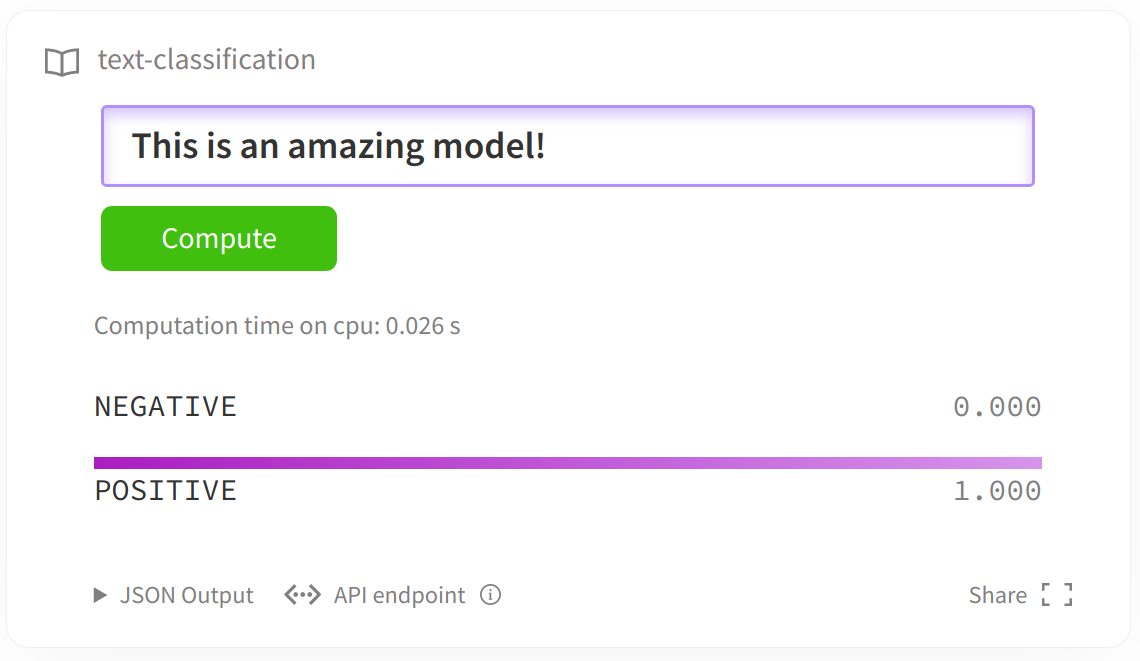

_**NOTE: You can run this demo in Sagemaker Studio, your local machine or Sagemaker Notebook Instances**_

# Development Environment and Permissions 

### Enterpirse-specific Environment setting example

In [47]:
%env HTTPS_PROXY=http://proxy.config.pcp.local:3128
%env HTTP_PROXY=http://proxy.config.pcp.local:3128
%env NO_PROXY=localhost,127.0.0.1,172.31.160.0/20,100.77.198.128/26,100.77.214.128/26,100.77.230.128/26,172.18.24.0/22,172.18.28.0/22,172.18.32.0/22,169.254.169.254,10.0.0.0/16,10.100.0.0/16,.internal,.execute-api.us-west-2.amazonaws.com,.s3.us-west-2.amazonaws.com,.us-west-2.eks.amazonaws.com,.us-west-2.vpce.amazonaws.com,amazonlinux.us-west-2.amazonaws.com,api.sagemaker.us-west-2.amazonaws.com,cloudformation.us-west-2.amazonaws.com,cloudtrail.us-west-2.amazonaws.com,codebuild-fips.us-west-2.amazonaws.com,codebuild.us-west-2.amazonaws.com,config.us-west-2.amazonaws.com,dynamodb.us-west-2.amazonaws.com,ec2.us-west-2.amazonaws.com,ec2messages.us-west-2.amazonaws.com,elasticloadbalancing.us-west-2.amazonaws.com,events.us-west-2.amazonaws.com,kinesis.us-west-2.amazonaws.com,kms.us-west-2.amazonaws.com,logs.us-west-2.amazonaws.com,monitoring.us-west-2.amazonaws.com,runtime.sagemaker.us-west-2.amazonaws.com,secretsmanager.us-west-2.amazonaws.com,servicecatalog.us-west-2.amazonaws.com,sns.us-west-2.amazonaws.com,ssm.us-west-2.amazonaws.com,ssmmessages.us-west-2.amazonaws.com,sts.us-west-2.amazonaws.com
%env http_proxy=http://proxy.config.pcp.local:3128
%env https_proxy=http://proxy.config.pcp.local:3128
%env no_proxy=localhost,127.0.0.1,172.31.160.0/20,100.77.198.128/26,100.77.214.128/26,100.77.230.128/26,172.18.24.0/22,172.18.28.0/22,172.18.32.0/22,169.254.169.254,10.0.0.0/16,10.100.0.0/16,.internal,.execute-api.us-west-2.amazonaws.com,.s3.us-west-2.amazonaws.com,.us-west-2.eks.amazonaws.com,.us-west-2.vpce.amazonaws.com,amazonlinux.us-west-2.amazonaws.com,api.sagemaker.us-west-2.amazonaws.com,cloudformation.us-west-2.amazonaws.com,cloudtrail.us-west-2.amazonaws.com,codebuild-fips.us-west-2.amazonaws.com,codebuild.us-west-2.amazonaws.com,config.us-west-2.amazonaws.com,dynamodb.us-west-2.amazonaws.com,ec2.us-west-2.amazonaws.com,ec2messages.us-west-2.amazonaws.com,elasticloadbalancing.us-west-2.amazonaws.com,events.us-west-2.amazonaws.com,kinesis.us-west-2.amazonaws.com,kms.us-west-2.amazonaws.com,logs.us-west-2.amazonaws.com,monitoring.us-west-2.amazonaws.com,runtime.sagemaker.us-west-2.amazonaws.com,secretsmanager.us-west-2.amazonaws.com,servicecatalog.us-west-2.amazonaws.com,sns.us-west-2.amazonaws.com,ssm.us-west-2.amazonaws.com,ssmmessages.us-west-2.amazonaws.com,sts.us-west-2.amazonaws.com

env: HTTPS_PROXY=http://proxy.config.pcp.local:3128
env: HTTP_PROXY=http://proxy.config.pcp.local:3128
env: NO_PROXY=localhost,127.0.0.1,172.31.160.0/20,100.77.198.128/26,100.77.214.128/26,100.77.230.128/26,172.18.24.0/22,172.18.28.0/22,172.18.32.0/22,169.254.169.254,10.0.0.0/16,10.100.0.0/16,.internal,.execute-api.us-west-2.amazonaws.com,.s3.us-west-2.amazonaws.com,.us-west-2.eks.amazonaws.com,.us-west-2.vpce.amazonaws.com,amazonlinux.us-west-2.amazonaws.com,api.sagemaker.us-west-2.amazonaws.com,cloudformation.us-west-2.amazonaws.com,cloudtrail.us-west-2.amazonaws.com,codebuild-fips.us-west-2.amazonaws.com,codebuild.us-west-2.amazonaws.com,config.us-west-2.amazonaws.com,dynamodb.us-west-2.amazonaws.com,ec2.us-west-2.amazonaws.com,ec2messages.us-west-2.amazonaws.com,elasticloadbalancing.us-west-2.amazonaws.com,events.us-west-2.amazonaws.com,kinesis.us-west-2.amazonaws.com,kms.us-west-2.amazonaws.com,logs.us-west-2.amazonaws.com,monitoring.us-west-2.amazonaws.com,runtime.sagemaker.us-we

In [2]:
kms_key = "XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXX"

sagemaker_session_bucket = "customer-specific-bucket-name" #do not include 's3://'

subnets = ["subnet-XXXXXXXXXXXXXXXXX", "subnet-XXXXXXXXXXXXXXXXX"]

security_group_ids = ["sg-XXXXXXXXXXXXXXXXX"]

vpc_config={
    "SecurityGroupIds": security_group_ids,
    "Subnets": subnets
}


#Note: currently, there is a 512 character limitation on the sise of environmental variable string
proxy_endpoint = "http://proxy.config.pcp.local:3128"
no_proxy_endpoint = "localhost,127.0.0.1,172.31.160.0/20,100.77.198.128/26,100.77.214.128/26,100.77.230.128/26,172.18.24.0/22,172.18.28.0/22,172.18.32.0/22,169.254.169.254,10.0.0.0/16,10.100.0.0/16,.internal,us-west-2.amazonaws.com,.us-west-2.amazonaws.com,.us-west-2.eks.amazonaws.com,.us-west-2.vpce.amazonaws.com"

env_variables_dict = {
    'http_proxy': proxy_endpoint, 
    'HTTP_PROXY': proxy_endpoint,
    'https_proxy': proxy_endpoint,
    'HTTPS_PROXY': proxy_endpoint,
    'NO_PROXY': no_proxy_endpoint,
    'no_proxy': no_proxy_endpoint,
}

In [3]:
env_variables_dict

{'http_proxy': 'http://proxy.config.pcp.local:3128',
 'HTTP_PROXY': 'http://proxy.config.pcp.local:3128',
 'https_proxy': 'http://proxy.config.pcp.local:3128',
 'HTTPS_PROXY': 'http://proxy.config.pcp.local:3128',
 'NO_PROXY': 'localhost,127.0.0.1,172.31.160.0/20,100.77.198.128/26,100.77.214.128/26,100.77.230.128/26,172.18.24.0/22,172.18.28.0/22,172.18.32.0/22,169.254.169.254,10.0.0.0/16,10.100.0.0/16,.internal,.apple.com,us-west-2.amazonaws.com,.us-west-2.amazonaws.com,.us-west-2.eks.amazonaws.com,.us-west-2.vpce.amazonaws.com',
 'no_proxy': 'localhost,127.0.0.1,172.31.160.0/20,100.77.198.128/26,100.77.214.128/26,100.77.230.128/26,172.18.24.0/22,172.18.28.0/22,172.18.32.0/22,169.254.169.254,10.0.0.0/16,10.100.0.0/16,.internal,.apple.com,us-west-2.amazonaws.com,.us-west-2.amazonaws.com,.us-west-2.eks.amazonaws.com,.us-west-2.vpce.amazonaws.com'}

## Installation

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if you haven´t it installed_

In [4]:
!pip install "sagemaker>=2.59.8" "transformers==4.12.3" "datasets[s3]==1.18.3" --upgrade --quiet

## Development environment 

In [5]:
import sagemaker.huggingface

## Permissions

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [ ]:
import sagemaker
import os
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)
region = sess.boto_region_name
nb_prefix = "01_pytorch_training"
code_location = os.path.join("s3://", sess.default_bucket(), nb_prefix, "code")
output_location = os.path.join("s3://", sess.default_bucket(), nb_prefix, "output")
print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")
print(f"sagemaker SDK version: {sagemaker.__version__}")
print(f"code_location: {code_location}")
print(f"output_location: {output_location}")


# Preprocessing

We are using the `datasets` library to download and preprocess the `imdb` dataset. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job. The [imdb](http://ai.stanford.edu/~amaas/data/sentiment/) dataset consists of 25000 training and 25000 testing highly polar movie reviews.

## Tokenization 

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'distilbert-base-uncased'

# dataset used
dataset_name = 'imdb'

# s3 key prefix for the data
s3_prefix = os.path.join(nb_prefix, 'samples/datasets/imdb')
s3_prefix

In [8]:
# load dataset
dataset = load_dataset(dataset_name)

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])
test_dataset = test_dataset.shuffle().select(range(10000)) # smaller the size for test dataset to 10k 


# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Reusing dataset imdb (/home/ec2-user/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset imdb (/home/ec2-user/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/2 [00:00<?, ?it/s]

Parameter 'generator'=Generator(PCG64) of the transform datasets.arrow_dataset.Dataset.shuffle couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

## Uploading data to `sagemaker_session_bucket`

After we processed the `datasets` we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [ ]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()  

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)
print(training_input_path)
# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)


# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job we need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator we define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in .....



```python
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            transformers_version='4.4',
                            pytorch_version='1.6',
                            py_version='py36',
                            role=role,
                            hyperparameters = {'epochs': 1,
                                               'train_batch_size': 32,
                                               'model_name':'distilbert-base-uncased'
                                                })
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required ec2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running. 

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. 

Sagemaker is providing useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run your training job locally you can define `instance_type='local'` or `instance_type='local_gpu'` for gpu usage. _Note: this does not working within SageMaker Studio_


In [12]:
#!pygmentize ./scripts/train.py

## Creating an Estimator and start a training job

In [13]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 1,
                 'train_batch_size': 32,
                 'model_name':'distilbert-base-uncased'
                 }

#### Typically, enterprise users are not allowed to create their own buckets since S3 buckets need to have security policies applied to them. Also any new S3 bucket name needs to be added to VPC S3 Endpoint secuirty policy. SageMaker estimator needs to have 'code_location' and 'output_location' parameters specified.

In [14]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.2xlarge',
                            volume_size = 100, #EBS volume (in GB) attached to the training instance
                            instance_count=1,
                            role=role,
                            transformers_version='4.12',
                            pytorch_version='1.9',
                            py_version='py38',
                            hyperparameters = hyperparameters,
                            environment=env_variables_dict,
                            code_location = code_location, 
                            volume_kms_key= kms_key,
                            output_kms_key= kms_key,
                            model_kms_key = kms_key,
                            output_path = output_location, 
                            subnets = subnets,
                            security_group_ids = security_group_ids,
                            encrypt_inter_container_traffic=True,
                            debugger_hook_config=False,
                            disable_profiler=True
                                   )

In [16]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path,'test': test_input_path}, job_name="distilbert-train-x4")

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: distilbert-train-x4


2023-04-19 23:55:33 Starting - Starting the training job...
2023-04-19 23:55:58 Starting - Preparing the instances for training......
2023-04-19 23:56:57 Downloading - Downloading input data...
2023-04-19 23:57:22 Training - Downloading the training image........................
2023-04-20 00:01:33 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-20 00:01:52,568 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-20 00:01:52,595 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-20 00:01:52,597 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-20 00:01:52,878 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
Num examples = 25000
***** Running training *****
  Num examples = 25000
Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
Total optimization steps = 782
Gradient Accumulation steps = 1
  Total optimization steps = 782
0%|          | 0/782 [00:00<?, ?it/s]
[2023-04-20 00:02:04.119 algo-1:27 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-20 00:02:04.157 algo-1:27 INFO profiler_config_parser.py:1

37%|███▋      | 291/782 [02:19<03:55,  2.09it/s]


56%|█████▌    | 438/782 [03:29<02:44,  2.09it/s]


64%|██████▍   | 500/782 [03:58<02:18,  2.03it/s]
{'loss': 0.3592, 'learning_rate': 5e-05, 'epoch': 0.64}
64%|██████▍   | 500/782 [03:58<02:18,  2.03it/s]
Saving model checkpoint to /opt/ml/model/checkpoint-500
Saving model checkpoint to /opt/ml/model/checkpoint-500
Configuration saved in /opt/ml/model/checkpoint-500/config.json
Configuration saved in /opt/ml/model/checkpoint-500/config.json
Model weights saved in /opt/ml/model/checkpoint-500/pytorch_model.bin
Model weights saved in /opt/ml/model/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /opt/ml/model/checkpoint-500/tokenizer_config.json
tokenizer config file saved in /opt/ml/model/checkpoint-500/tokenizer_config.json
Special tokens file saved in /opt/ml/model/checkpoint-500/special_tokens_map.json
Special tokens file saved in /opt/ml/model/checkpoint-500/special_tokens_map.json
73%|███████▎  | 570/782 [04:34<01:42,  2.08it/s]


93%|█████████▎| 726/782 [05:48<00:26,  2.08it/s]


100%|██████████| 782/782 [06:15<00:00,  2.66it/s]
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
***** Running Evaluation *****
Num examples = 10000
  Batch size = 64
Num examples = 10000
  Batch size = 64
45%|████▌     | 71/157 [00:23<00:28,  3.01it/s]#033[A


99%|█████████▉| 156/157 [00:51<00:00,  3.02it/s]#033[A
#033[A
{'eval_loss': 0.18592776358127594, 'eval_accuracy': 0.931, 'eval_f1': 0.9301760777170612, 'eval_precision': 0.9343362472047164, 'eval_recall': 0.926052790650816, 'eval_runtime': 51.9623, 'eval_samples_per_second': 192.447, 'eval_steps_per_second': 3.021, 'epoch': 1.0}
#015100%|██████████| 157/157 [00:51<00:00,  3.02it/s]#033[A
#033[A
Training completed. Do not forget to share your model on huggingface.co/models =)
Training completed. Do not forget to share your model on huggingface.co/models =)
{'train_runtime': 427.429, 'train_samples_per_second': 58.489, 'train_steps_per_second': 1.83, 'train_loss': 0.31564076416327824, 'epoch': 1.0}
100%|██████████| 782/782 [07:07<00:00,  1.83it/s]
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
The following columns in the evaluation set  don't have a corresponding argument in `

100%|██████████| 157/157 [00:51<00:00,  3.05it/s]
***** Eval results *****
Saving model checkpoint to /opt/ml/model
Saving model checkpoint to /opt/ml/model
Configuration saved in /opt/ml/model/config.json
Configuration saved in /opt/ml/model/config.json
Model weights saved in /opt/ml/model/pytorch_model.bin
Model weights saved in /opt/ml/model/pytorch_model.bin
tokenizer config file saved in /opt/ml/model/tokenizer_config.json
tokenizer config file saved in /opt/ml/model/tokenizer_config.json
Special tokens file saved in /opt/ml/model/special_tokens_map.json
Special tokens file saved in /opt/ml/model/special_tokens_map.json
2023-04-20 00:10:04,183 sagemaker-training-toolkit INFO     Waiting for the process to finish and give a return code.
2023-04-20 00:10:04,184 sagemaker-training-toolkit INFO     Done waiting for a return code. Received 0 from exiting process.
2023-04-20 00:10:04,184 sagemaker-training-toolkit INFO     Reporting training SUCCESS

2023-04-20 00:10:11 Uploading - Uplo

## Deploying the model onto the endpoint using the estimator

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type.

In [17]:
#predictor = huggingface_estimator.deploy(1,"ml.p4d.24xlarge", kms_key=kms_key) #deploy on GPU
#predictor = huggingface_estimator.deploy(1,"ml.p3.2xlarge", kms_key=kms_key) #deploy on GPU
predictor = huggingface_estimator.deploy(1,"ml.c5.4xlarge", kms_key=kms_key) #deploy on CPU

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: huggingface-pytorch-training-2023-04-20-00-12-55-403
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-training-2023-04-20-00-12-55-403
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-training-2023-04-20-00-12-55-403


----!

Then, we use the returned predictor object to call the endpoint.

In [18]:
sentiment_input= {"inputs":"I love using the new Inference DLC."}
predictor.predict(sentiment_input)

[{'label': 'LABEL_1', 'score': 0.9483873844146729}]

Finally, we delete the endpoint again.

In [19]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: huggingface-pytorch-training-2023-04-20-00-12-55-403
INFO:sagemaker:Deleting endpoint with name: huggingface-pytorch-training-2023-04-20-00-12-55-403


# Extras

### Estimator Parameters

In [ ]:
# container image used for training job
print(f"container image used for training job: \n{huggingface_estimator.image_uri}\n")

# s3 uri where the trained model is located
print(f"s3 uri where the trained model is located: \n{huggingface_estimator.model_data}\n")

# latest training job name for this estimator
print(f"latest training job name for this estimator: \n{huggingface_estimator.latest_training_job.name}\n")



In [21]:
# access the logs of the training job
huggingface_estimator.sagemaker_session.logs_for_job(huggingface_estimator.latest_training_job.name)

2023-04-20 00:12:32 Starting - Preparing the instances for training
2023-04-20 00:12:32 Downloading - Downloading input data
2023-04-20 00:12:32 Training - Training image download completed. Training in progress.
2023-04-20 00:12:32 Uploading - Uploading generated training model
2023-04-20 00:12:32 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-20 00:01:52,568 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-20 00:01:52,595 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-20 00:01:52,597 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-20 00:01:52,878 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "train

### Attach an old training job to an estimator 

In Sagemaker you can attach an old training job to an estimator to continue training, get results etc..

In [22]:
from sagemaker.estimator import Estimator

# job which is going to be attached to the estimator
# old_training_job_name must exit, else the cell below will fail
old_training_job_name='train-02'

In [ ]:
# attach old training job
huggingface_estimator_loaded = Estimator.attach(old_training_job_name)

# get model output s3 from training job
huggingface_estimator_loaded.model_data

### Deploying a previously trained model to an endpoint 

#### (the model could be trained on SageMaker or elsewhere)

In [24]:
s3_model_uri=huggingface_estimator.model_data #S3 location of model.tar.gz file
#or specify model.tar.gz file location explicitly as below
from sagemaker.huggingface.model import HuggingFaceModel
hugface_model = HuggingFaceModel(
    model_data=s3_model_uri,
    role=role,
    sagemaker_session=sess,
    transformers_version='4.12',
    pytorch_version='1.9',
    py_version='py38',
    env=env_variables_dict, #note 'env' vs 'environment' in HuggingFace Training Estimator above
    model_kms_key= kms_key,
    vpc_config=vpc_config,
    code_location=code_location
)

In [26]:
#deploy the model to an endpoint
predictor2 = hugface_model.deploy(1,"ml.c5.4xlarge", kms_key=kms_key)

INFO:sagemaker:Creating model with name: huggingface-pytorch-inference-2023-04-20-00-15-43-934
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-inference-2023-04-20-00-15-44-528
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-inference-2023-04-20-00-15-44-528


----!

In [27]:
# This is how to find out your endpoint name if you haven't specified it in the HuggingFace model above 
print(f"Endpoint Name: \n{predictor2.endpoint_name}\n")

Endpoint Name: 
huggingface-pytorch-inference-2023-04-20-00-15-44-528



In [28]:
predictor2.predict(sentiment_input)

[{'label': 'LABEL_1', 'score': 0.9483873844146729}]

#### Exposing all logits in the model:

In [29]:
sentiment_input_all_logits = {"inputs": "I love using the new Inference DLC.", "parameters": {"return_all_scores": True}}
predictor2.predict(sentiment_input_all_logits) 

[[{'label': 'LABEL_0', 'score': 0.05161254107952118},
  {'label': 'LABEL_1', 'score': 0.9483873844146729}]]

### Adding a Tokenizer and Creating a HuggingFace Inference Pipeline

#### Let us further enhance distilbert-base-uncased model by adding a tokenizer. This may be necessary because BERT model has a limitation on the size of the input (512). If you get an inference error "The size of tensor a ... must match the size of tensor b (512)... ", your input is likely larger than 512. One way to deal with it is to create a HuggingFace pipeline with a Tokenizer preceeding the model itself. 
##### attibution: Ravi Taja Sunkara; Apple, Inc


##### Download the preivously trained model from S3
for educational purposes, in this cell we use SageMaker S3 downloader utility as opposed to boto3 used at the top of the notebook. Both methods work equally well.

In [30]:
from sagemaker.s3 import S3Downloader, S3Uploader
S3Downloader.download(s3_uri = s3_model_uri, 
                                   local_path = './saved_model', 
                                   sagemaker_session=sess
                     )

In [31]:
!cd ./saved_model && tar -xvf model.tar.gz 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
special_tokens_map.json
tokenizer_config.json
vocab.txt
training_args.bin
checkpoint-500/
checkpoint-500/optimizer.pt
checkpoint-500/special_tokens_map.json
checkpoint-500/tokenizer_config.json
checkpoint-500/vocab.txt
checkpoint-500/scheduler.pt
checkpoint-500/training_args.bin
checkpoint-500/trainer_state.json
checkpoint-500/rng_state.pth
checkpoint-500/pytorch_model.bin
checkpoint-500/tokenizer.json
checkpoint-500/config.json
pytorch_model.bin
tokenizer.json
config.json


In [32]:
!cd ./saved_model && rm -rf checkpoint-*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Create HuggingFace pipeline with a tokenizer

In [33]:
from transformers import TextClassificationPipeline
from transformers import AutoModelForSequenceClassification
pipe_model = AutoModelForSequenceClassification.from_pretrained('./saved_model')
tokenizer = AutoTokenizer.from_pretrained('./saved_model')
pipe=TextClassificationPipeline(model=pipe_model, tokenizer=tokenizer, return_all_scores=True)
print(pipe("phone"))


[[{'label': 'LABEL_0', 'score': 0.5096686482429504}, {'label': 'LABEL_1', 'score': 0.4903312921524048}]]


#### Save the pipeline model on disk and tarball it in order to deploy it on SageMaker endpoint later.

In [34]:
pipe.save_pretrained(save_directory="./saved_model")

In [35]:
!cd ./saved_model && rm -rf .ipynb_checkpoints/
!cd ./saved_model && rm model.tar.gz
!cd ./saved_model && tar -zcvf pipe_model.tar.gz .

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
./
./tokenizer_config.json
.

In [36]:
from datetime import datetime
pipe_model_s3_uri_prefix=os.path.join(output_location, datetime.now().strftime("%m%d%I%p"), 
                               "pipe_model")

In [38]:
pipe_model_s3_uri=S3Uploader.upload(desired_s3_uri = pipe_model_s3_uri_prefix, 
                                   local_path = './saved_model/pipe_model.tar.gz', 
                                   sagemaker_session=sess
                     )

In [39]:
!cd ./saved_model && rm pipe_model.tar.gz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Distilbert model is capable of multiple tasks; we are interested in 'text-classification'; need to pass this parameter to HuggingFaceModel object

In [40]:
env_variables_dict["HF_TASK"]="text-classification"
env_variables_dict

{'http_proxy': 'http://proxy.config.pcp.local:3128',
 'HTTP_PROXY': 'http://proxy.config.pcp.local:3128',
 'https_proxy': 'http://proxy.config.pcp.local:3128',
 'HTTPS_PROXY': 'http://proxy.config.pcp.local:3128',
 'NO_PROXY': 'localhost,127.0.0.1,172.31.160.0/20,100.77.198.128/26,100.77.214.128/26,100.77.230.128/26,172.18.24.0/22,172.18.28.0/22,172.18.32.0/22,169.254.169.254,10.0.0.0/16,10.100.0.0/16,.internal,.apple.com,us-west-2.amazonaws.com,.us-west-2.amazonaws.com,.us-west-2.eks.amazonaws.com,.us-west-2.vpce.amazonaws.com',
 'no_proxy': 'localhost,127.0.0.1,172.31.160.0/20,100.77.198.128/26,100.77.214.128/26,100.77.230.128/26,172.18.24.0/22,172.18.28.0/22,172.18.32.0/22,169.254.169.254,10.0.0.0/16,10.100.0.0/16,.internal,.apple.com,us-west-2.amazonaws.com,.us-west-2.amazonaws.com,.us-west-2.eks.amazonaws.com,.us-west-2.vpce.amazonaws.com',
 'HF_TASK': 'text-classification'}

In [41]:
# Create HuggingFace SageMaker Model object 
from sagemaker.huggingface.model import HuggingFaceModel
hugface_model_pipe = HuggingFaceModel(
    model_data=pipe_model_s3_uri,
    role=role,
    sagemaker_session=sess,
    transformers_version='4.12',
    pytorch_version='1.9',
    py_version='py38',
    env=env_variables_dict, #note 'env' vs 'environment' in HuggingFace Training Estimator above
    model_kms_key= kms_key,
    vpc_config=vpc_config,
    code_location=code_location
)

In [42]:
#Deploy the endpoint
predictor_pipe = hugface_model_pipe.deploy(1,"ml.c5.4xlarge", kms_key=kms_key)

INFO:sagemaker:Creating model with name: huggingface-pytorch-inference-2023-04-20-00-18-59-124
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-inference-2023-04-20-00-18-59-711
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-inference-2023-04-20-00-18-59-711


----!

In [43]:
sentiment_input_all_logits

{'inputs': 'I love using the new Inference DLC.',
 'parameters': {'return_all_scores': True}}

In [44]:
# Invoke the endpoint
# note that even though we passed because we passed the parameter "return_all_scores=True" when we created 
# HuggingFace pipeline, it is still just a model parameter which defaults to "False".
# https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html#transformers.TextClassificationPipeline
# Thus, if we want to display all the logits, we need to pass it with every input. 
predictor_pipe.predict(sentiment_input_all_logits)

[[{'label': 'LABEL_0', 'score': 0.05161254107952118},
  {'label': 'LABEL_1', 'score': 0.9483873844146729}]]

In [45]:
#Final clean-up
predictor_pipe.delete_endpoint()
predictor2.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: huggingface-pytorch-inference-2023-04-20-00-18-59-711
INFO:sagemaker:Deleting endpoint with name: huggingface-pytorch-inference-2023-04-20-00-18-59-711
INFO:sagemaker:Deleting endpoint configuration with name: huggingface-pytorch-inference-2023-04-20-00-15-44-528
INFO:sagemaker:Deleting endpoint with name: huggingface-pytorch-inference-2023-04-20-00-15-44-528
